In [115]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from tqdm.notebook import tqdm
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn import preprocessing

In [133]:
# генерируем датафрейм
sample_size = 10_000
MEAN = 3
STD = 1

#distribution = stats.lognorm(loc=MEAN, scale=STD)

metric = np.random.normal(MEAN, STD, sample_size).reshape(1, sample_size)
log_metric = np.random.lognormal(MEAN, STD, sample_size).reshape(1, sample_size)
def normalization_data(metric):
    min_max_scaler = preprocessing.MinMaxScaler()
    normal_metric = min_max_scaler.fit_transform(metric)
    return normal_metric

normal_metric = normalization_data(metric)
user_id = np.arange(sample_size).reshape(1,sample_size)
starta_1 = np.random.randint(5, size=sample_size).reshape(1, sample_size)
starta_2 = np.random.randint(3, size=sample_size).reshape(1, sample_size) + 10
cols = ['user_id', 'metric', 'strata_1', 'strata_2']

df = pd.DataFrame(
    data=np.concatenate((user_id, log_metric, starta_1, starta_2), axis=0).T,
    columns=cols
    )

In [72]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (15, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

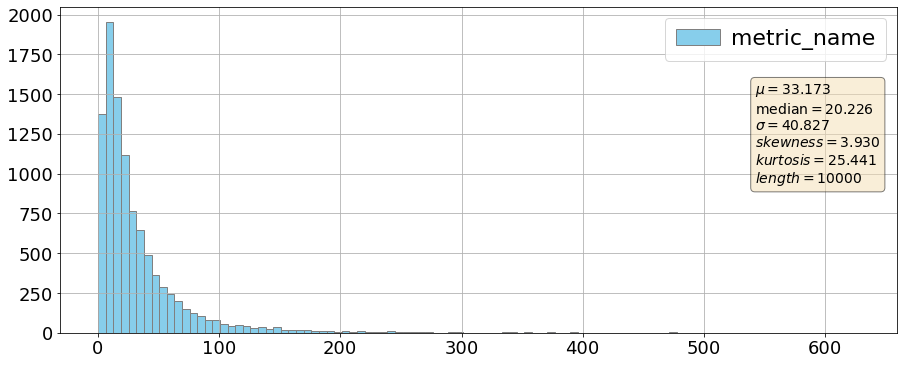

In [203]:
# посмотрим на распределение сырых данных

def data_distribution_plot(metric):
    
    metric = metric
    data_mean = round(np.mean(metric), 4)
    data_std = round(np.std(metric), 4)
    data_median = round(np.median(metric), 4)
    skewness_ = round(skew(metric), 4)
    kurtosis_ = round(kurtosis(metric), 4)
    lenght = len(metric)
    
    fig, ax = plt.subplots()
    ax.hist(metric, color='skyblue', ec='grey', bins=100)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textstr = '\n'.join((
        r'$\mu=%.3f$' % (data_mean, ),
        r'$\mathrm{median}=%.3f$' % (data_median, ),
        r'$\sigma=%.3f$' % (data_std, ),
        r'$skewness=%.3f$' % (skewness_, ),
        r'$kurtosis=%.3f$' % (kurtosis_, ),
        r'$length=%.0f$' % (lenght, ),
        ))

    ax.text(0.83, 0.77, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.legend(['metric_name'])
    plt.grid()
    plt.show()

data_distribution_plot(metric)

In [151]:
# попробуем снизить дисперсию данных за счет стратификации
# TODO доработать функцию так, чтобы деление на не равные группы или вынести это в другую функцию
def stratified_without_group(data, strat_columns, val_list, group_size, weight, group_count=2, larger_group_weight=0.5, verbose=False):
    strat_df = data[data[strat_columns].isin(val_list).all(axis=1)].reset_index(drop=True)
    one_group_size = int(round(group_size * weight)) * group_count
    try:
        random_indexes_for_one_group = np.random.choice([i for i in range(len(strat_df))], one_group_size, False)
    except ValueError:
        print('Объем выборки превышает объем входных данных.')
    random_strata_df = strat_df.iloc[random_indexes_for_one_group,:]
    if verbose:
        print(f'Размер датафрейма страты {val_list}: {len(strat_df)}')
        print(f'one_group_size страты {val_list}: {one_group_size}')
        print(f'Количество случайных индексов, всего: {len(random_indexes_for_one_group)}')
        print(f'Количество отобранных индексов: {len(random_indexes_for_one_group)}')
        print(f'Количество строк в датафрейме страты: {len(random_strata_df)}')
    return random_strata_df


def select_stratified_data(data, strat_columns, group_size, larger_group_weight=None, group_count=2, weights=None, seed=None, verbose=False):
    """
    Выравнивает общий датафрейм в соответствии с весами

    data - pd.DataFrame, датафрейм с описанием объектов, содержит атрибуты для стратификации.
    group_size - int, размер одной группы
    group_count - int, количество групп (по умолчанию 2)
    strat_columns - List[str], список названий столбцов, по которым нужно стратифицировать.
    weights - dict, словарь весов страт {strat: weight}, где strat - либо tuple значений элементов страт,
        например, для strat_columns=['os', 'gender', 'birth_year'] будет ('ios', 'man', 1992), либо просто строка/число.
        Если None, определить веса пропорционально доле страт в датафрейме data.
    seed - int, исходное состояние генератора случайных чисел для воспроизводимости
        результатов. Если None, то состояние генератора не устанавливается.

    return stratified_data - один датафрейм того же формата, что и data, колиество строк = group_size * group_count
    """
    # YOUR_CODE_HERE
    np.random.seed(seed)
    
    stratified_df = pd.DataFrame(columns=strat_columns)
    if weights:
        for strata, weight in weights.items():
            if isinstance(strata, (str, int, float)):
                val_list = []
                val_list += [strata]
            else:
                val_list = list(strata)
            try:
                one_strata_df = stratified_without_group(data, val_list, strat_columns, group_size, weight, group_count, verbose)
                stratified_df = pd.concat([stratified_df, one_strata_df], ignore_index=True)
            except UnboundLocalError:
                print('Нарушена индексация. Проверьте границы входимости индексов в датафрейм')
                return
    else:
        strat_dict = data.groupby(strat_columns).count().iloc[:,0].to_dict()
        len_data = len(df)
        strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
        for strat, weight in strat_dict_shares.items():
            if isinstance(strat, (str, int, float)):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
            try:
                one_strata_df = stratified_without_group(data, strat_columns, val_list, group_size, weight, group_count, verbose)
                stratified_df = pd.concat([stratified_df, one_strata_df], ignore_index=True)
            except UnboundLocalError:
                print('Нарушена индексация. Проверьте границы входимости индексов в датафрейм')
                return  
    return stratified_df

In [157]:
def get_random_group(data, group_size, seed=None):
    np.random.seed(seed)
    random_indexes_for_one_group = np.random.choice([i for i in range(len(data))], group_size, False)
    return data.iloc[random_indexes_for_one_group,:]

In [205]:
stratified_means = []
for _ in tqdm(range(1)):
    t = select_stratified_data(df, ['strata_1', 'strata_2'], 4000, weights=None, seed=None)
    strat_means = t.groupby(['strata_1', 'strata_2']).agg({'metric': 'mean'})
    stratified_mean = strat_means['metric'].mean()
    stratified_means.append(stratified_mean)
np.mean(stratified_means), np.var(stratified_means)

  0%|          | 0/1 [00:00<?, ?it/s]

(32.742475041877775, 0.0)

In [196]:
simple_mean = []
for _ in tqdm(range(10_000)):
    t = get_random_group(df, 4000, seed=None)
    mean = t['metric'].mean()
    simple_mean.append(mean)
np.mean(simple_mean), np.var(simple_mean)

  0%|          | 0/10000 [00:00<?, ?it/s]

(33.17908869095761, 0.24859975901323855)

In [197]:
0.24859975901323855 / 0.04262964566147756

5.8316168280489995

In [315]:
t = select_stratified_data(df, ['strata_1', 'strata_2'], 4000, weights=None, seed=None)
strat_means = t.groupby(['strata_1', 'strata_2']).agg({'metric': 'mean'})
stratified_std = strat_means['metric'].std()
stratified_std

1.683441160488941

In [269]:
t = get_random_group(df, 4000, seed=None)
simple_std = t['metric'].std()
simple_std

40.43139583345752

In [153]:
# Стратификация с разбиением на пилот и контроль

def stratified_with_group(data, strat_columns, val_list, group_size, weight):
    strat_df = data[data[strat_columns].isin(val_list).all(axis=1)].reset_index(drop=True)
    ab_group_size = int(round(group_size * weight))
    random_indexes_ab = np.random.choice([i for i in range(len(strat_df))], ab_group_size * 2, False)
    a_indexes = random_indexes_ab[:ab_group_size]
    b_indexes = random_indexes_ab[ab_group_size:]
    a_random_strata_df = strat_df.iloc[a_indexes,:]
    b_random_strata_df = strat_df.iloc[b_indexes,:]
    
    return a_random_strata_df, b_random_strata_df

def select_stratified_groups(data, strat_columns, group_size, weights=None, seed=None):
    """
    Подбирает стратифицированные группы для эксперимента.

    data - pd.DataFrame, датафрейм с описанием объектов, содержит атрибуты для стратификации.
    strat_columns - List[str], список названий столбцов, по которым нужно стратифицировать.
    group_size - int, размеры групп.
    weights - dict, словарь весов страт {strat: weight}, где strat - либо tuple значений элементов страт,
        например, для strat_columns=['os', 'gender', 'birth_year'] будет ('ios', 'man', 1992), либо просто строка/число.
        Если None, определить веса пропорционально доле страт в датафрейме data.
    seed - int, исходное состояние генератора случайных чисел для воспроизводимости
        результатов. Если None, то состояние генератора не устанавливается.

    return (data_pilot, data_control) - два датафрейма того же формата, что и data
        c пилотной и контрольной группами.
    """
    # YOUR_CODE_HERE
    np.random.seed(seed)
    
    pilot = pd.DataFrame(columns=strat_columns)
    control = pd.DataFrame(columns=strat_columns)
    if weights:
        for strat, weight in weights.items():
            if isinstance(strat, (str, int, float)):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
            
            a_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[0]
            b_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[1]
  
            control = pd.concat([control, a_random_strata_df], ignore_index=True)
            pilot = pd.concat([pilot, b_random_strata_df], ignore_index=True)
    else:
        strat_dict = data.groupby(strat_columns).count().iloc[:,0].to_dict()
        len_data = len(data)
        strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
        for strat, weight in strat_dict_shares.items():
            if isinstance(strat, (str, int, float)):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
            a_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[0]
            b_random_strata_df = stratified_with_group(data, strat_columns, val_list, group_size, weight)[1]
   
            control = pd.concat([control, a_random_strata_df], ignore_index=True)
            pilot = pd.concat([pilot, b_random_strata_df], ignore_index=True)
    return (pilot, control)

In [163]:
pilot = select_stratified_groups(df, ['starta_1', 'starta_2'], 500, weights=None, seed=42)[0]
control = select_stratified_groups(df, ['starta_1', 'starta_2'], 500, weights=None, seed=42)[1]

In [164]:
pilot.groupby(['starta_1', 'starta_2'])['user_id'].count().to_frame()

user_id
starta_1 starta_2         
0.0      0.0           107
         1.0            20
         2.0            18
1.0      0.0             9
         1.0           114
         2.0            15
2.0      0.0            19
         1.0            15
         2.0            86
3.0      0.0            19
         1.0            16
         2.0            17
4.0      0.0            15
         1.0             9
         2.0            25

In [165]:
control.groupby(['starta_1', 'starta_2'])['user_id'].count().to_frame()

user_id
starta_1 starta_2         
0.0      0.0           104
         1.0            11
         2.0            19
1.0      0.0            14
         1.0           102
         2.0            14
2.0      0.0            21
         1.0            18
         2.0            92
3.0      0.0            17
         1.0            17
         2.0            13
4.0      0.0            21
         1.0            14
         2.0            19

In [8]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)


def check_mannwhitneyu(a, b, alpha=0.05):
    """Тест Манн-Уитни. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.mannwhitneyu(a, b, alternative='two-sided')
    return int(pvalue < alpha)


def check_bootstrap(a, b, func=np.mean, B=1000, alpha=0.05):
    """Бутстрап. Возвращает 1, если отличия значимы."""
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))
    list_diff = func(a_bootstrap, axis=0) - func(b_bootstrap, axis=0)
    left_bound = np.quantile(list_diff, alpha / 2)
    right_bound = np.quantile(list_diff, 1 - alpha / 2)
    res = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return res

In [54]:
res = []
for _ in tqdm(range(100)):
    pval = []
    for _ in range(1000):
        a = np.random.normal(0, 1, 1000)
        b = np.random.normal(0.02, 1, 1000)
        pval.append(check_ttest(a, b))
    res.append(np.mean(pval))

  0%|          | 0/100 [00:00<?, ?it/s]

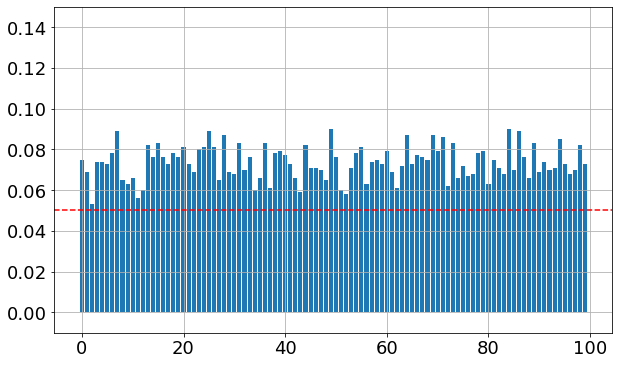

In [55]:
plt.bar([i for i in range(len(res))], res)
plt.ylim([-0.01, 0.15])
plt.axhline(y = 0.05, color = 'r', linestyle = '--')
plt.grid()
plt.show()

In [56]:
np.mean(res)

0.07352999999999998